# <center> Практические задания по цифровой обработке сигналов </center>
# <center> Вторая лабораторная работа </center>
# <center> Анализ сигналов </center>

In [45]:
import librosa
import numpy as np
import scipy 
import scipy.fft
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import librosa.filters
import hashlib
import math
from numpy.lib.stride_tricks import as_strided
from scipy.fft import fft, fftfreq
from scipy.interpolate import interp1d
from scipy.signal import hilbert
from scipy.signal import find_peaks

# Запретим numpy выполнять деление на 0
np.seterr(divide='raise', invalid='raise') 
%matplotlib inline

In [2]:
# Определим две функции для отрисовки сигнала. 
def draw_waveform(wav, sr, figsize=(14, 5)):
    # Отрисовка звукового сигнала во временной области
    plt.figure(figsize=figsize)
    librosa.display.waveplot(wav, sr=sr)

def draw_sig(frames, name=None, figsize=(14, 3)):
    # Отрисовка сигнала в виде "леденцов на палочке"
    plt.figure(figsize=figsize)
    plt.stem(frames)
    if name is not None:
        plt.legend([name])
    plt.xlabel("n")
    plt.ylabel("Energy")
    plt.show()
    

In [3]:
# Создадим несколько простых сигналов. Они нам понадобятся для дальшейшего тестирования
signals = {}

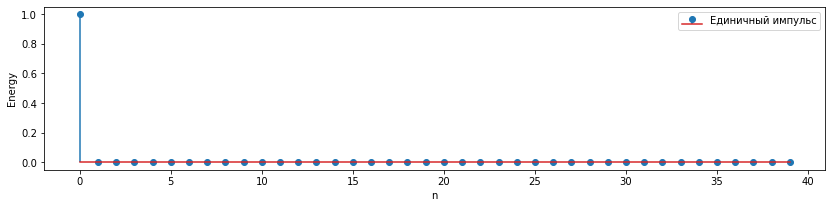

In [4]:
name = "Единичный импульс"
signals[name] = np.array([1] + [0]*39, dtype=float)
draw_sig(signals[name], name)

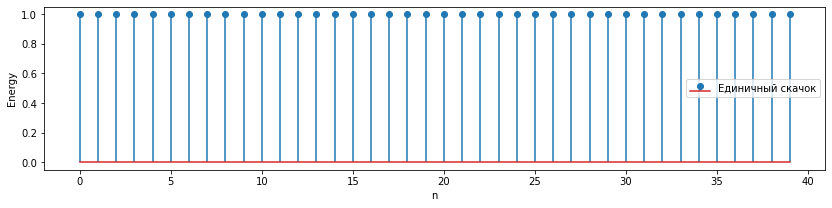

In [5]:
name = "Единичный скачок"
signals[name] = np.array([1]*40 ,dtype=float) 
draw_sig(signals[name], name)

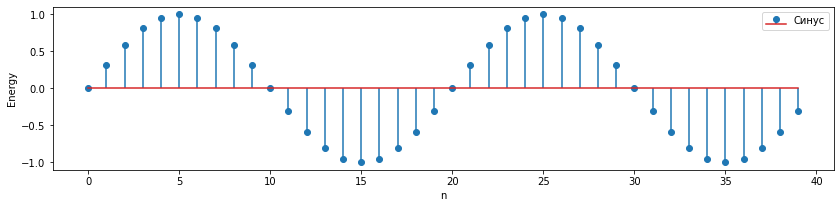

In [6]:
name = "Синус"
signals[name] = np.sin(np.pi * np.arange(40)/10)
draw_sig(signals[name], name)

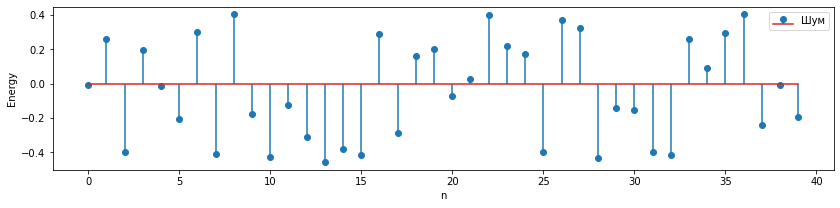

In [7]:
name = "Шум"
signals[name] = np.random.random(40)-0.5
draw_sig(signals[name], name)

-------------------------------
# Преобразование Фурье
Прежде, чем перейти к анализу сигналов, надо разобраться, что такое преобразование Фурье. 
> Преобразование Фурье (символ ℱ) — операция, сопоставляющая одной функции вещественной переменной другую функцию вещественной переменной. Эта новая функция описывает коэффициенты («амплитуды») при разложении исходной функции на элементарные составляющие — гармонические колебания с разными частотами (подобно тому, как музыкальный аккорд может быть выражен в виде суммы музыкальных звуков, которые его составляют). [Wiki](https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%B5%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%A4%D1%83%D1%80%D1%8C%D0%B5)



Формула прямого дискретного преобразования Фурье (ДПФ, Discrete Fourier Transform, DFT)):
$$ X_k = \sum_{n=0}^{N-1} x_n * e^{2i\pi k n/N} $$


# Задание 1 (2 балла)
Реализовать дискретное преобразование Фурье. Сравнить с реализацией scipy.fft.fft

In [8]:
def DFT(x):
    n = len(x)
    return np.array([sum((x[k] * np.exp(-2j * np.pi * i * k / n) for k in range(n))) for i in range(n)])

In [9]:
def test_DTF(x, transform=DFT):
    # Сравнение с библиотекой scipy
    scipy_result = scipy.fft.fft(x)
    curr_result = transform(x)
    if scipy_result.shape != curr_result.shape:
        print("TEST_FAILED")
        print(f"Your spectrogram shape is {curr_result.shape}. "
              f"Scipy spectrogram shape is {scipy_result.shape}")
        return -1
    if not np.allclose(curr_result, scipy_result):
        print("TEST FAILED")
        print(f"scipy spectrogram: {scipy_result}")
        print(f"Your DTF spectrogram: {curr_result}")
        print(f"Average diff is {np.mean(np.abs(scipy_result - curr_result))}")
        return -2
    print("TEST PASSED")
    return 0

for name, sig in signals.items():
    print(f"Checking '{name}'")
    assert test_DTF(sig) == 0, "Check you implementation"
print("All ok!")

Checking 'Единичный импульс'
TEST PASSED
Checking 'Единичный скачок'
TEST PASSED
Checking 'Синус'
TEST PASSED
Checking 'Шум'
TEST PASSED
All ok!


Класическое ДПФ имеет существенный недостаток - сложность алгоритма $O(N^2)$. На данный момент существуют чуть более сложные реализации преобразования Фурье, которые избавляются от квадратичной сложности. Например, алгоритм быстрого преобразования Фурье (Fast Fourier Transform, FFT) имеет сложность $O(N log(N))$, что делает его значительно более быстрым на длинных последовательностях. 

# Задание 1.1* (1 балл)
Реализовать быстрое преобразование Фурье. Сравнить с scipy.fft.fft

In [12]:
def FFT(x):
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    
    if N % 2 > 0:
        raise ValueError(f"размер x должен быть степень 2, твой N = {N}")
    elif N <= 16:
        return DFT(x)
    else:
        l = FFT(x[::2])
        r = FFT(x[1::2])
        base = np.exp(-2j * np.pi * np.arange(N) / N)
        return np.concatenate([l + base[:int(N / 2)] * r,
                               l + base[int(N / 2):] * r])

In [13]:
for name, sig in signals.items():
    print(f"Checking '{name}'")
    assert test_DTF(sig, transform=FFT) == 0, "Check you implementation"
print("All ok!")

Checking 'Единичный импульс'
TEST PASSED
Checking 'Единичный скачок'
TEST PASSED
Checking 'Синус'
TEST PASSED
Checking 'Шум'
TEST PASSED
All ok!


# Амплитудный и фазовый спектры
Поскольку преобразование Фурье определено в комплекстной области, анализировать результат напрямую проблематично. Для анализа сигналов принято разбивать результат преобразования Фурье на два спектра: амплитудный и фазовый. Амплитудный показывает, как меняется модуль сигнала, а фазовый - как меняется угол, образуемый на комплексной плоскости. 
# Задание 2 (1 балл)

Реализовать функции построения амплитудного и фазового спектра

In [14]:
#функция построения амплитудного спектра
def get_magnitude_from_spec(spec):
    return np.abs(spec)

#функция построения фазового спектра
def get_phi_from_spec(spec):
    return np.angle(spec)

In [15]:
def check_mean_var(sig, mean=None, var=None):
    if mean is not None and np.mean(sig) != mean:
        print(f"Bad mean. Expected {mean}, got {np.mean(sig)}")
        return False
    if var is not None and np.var(sig) != var:
        print(f"Bad var. Expected {var}, got {np.var(sig)}")
        return False
    return True

_spec = scipy.fft.fft(np.array([1]+[0]*10))
assert check_mean_var(get_magnitude_from_spec(_spec), 1.0, 0.0), \
    "Wrong magnitude"
assert check_mean_var(get_phi_from_spec(_spec), 0.0, 0.0), \
    "Wrong phase"

    
_spec = scipy.fft.fft(np.array([1]*10))
assert check_mean_var(get_magnitude_from_spec(_spec), 1.0, 9.0), \
    "Wrong  magnitude"
assert get_magnitude_from_spec(_spec)[0] == 10, \
    "Wrong magnitude"
assert get_phi_from_spec(_spec)[0] == 0, \
    "Wrong phase"

_spec = scipy.fft.fft(scipy.fft.ifft(np.array([0] + [10+5j]+[0]*6 + [10-5j])))
assert get_magnitude_from_spec(_spec).round(1)[1] == 11.2 , \
    "Wrong magnitude. Make sure it is a complex number module."
assert get_phi_from_spec(_spec).round(1)[1] == 0.5 , \
    "Wrong phase. Make sure it is an angle."

   
print("All OK!")

All OK!


In [16]:
# Определим еще одну функцию для отрисовки
# Теперь будем рисовать сигнал в частотной области
def draw_spec(spec, name=None, draw_A=True, draw_p=True, figsize=(14, 3)):
    if len(spec)<100:
        # Рисуем точки как "леденцы на палочках"
        draw_func = plt.stem
    else:
        # При большом N "леденцы" выглядят плохо, 
        # Поэтому будем рисовать огибающую функцию
        draw_func = plt.plot
    
    if draw_A:
        plt.figure(figsize=figsize)
        plt.title("Magnitude spectrum")
        spec_A = get_magnitude_from_spec(spec)
        draw_func(spec_A)
        plt.ylabel("Magnitude")
        plt.xlabel("n")
        plt.ylim(0, 10)
        if name is not None:
            plt.legend([name])
        plt.show()
        
    if draw_p:
        plt.figure(figsize=figsize)
        plt.title("Phase spectrum")
        phi = get_phi_from_spec(spec)
        draw_func(phi)
        plt.ylabel("Radian")
        plt.xlabel("n")
        if name is not None:
            plt.legend([name])
        plt.show()
    return 

# Задание 2.1 (0.5 балла)
Постройте спектры для всех сигналов из коллекции signals и ответьте на вопросы:
1. Почему амплитуда всех гармоник единичного импульса равна константе? 
1. Какие выводы можно сделать смотря на амплитудный спектр? А на фазовый? 
1. Как перевести номер отсчета в частоту?  
1. Что в фазовом спектре является полезной информацией, а что - шумом? Почему?

In [18]:
spec_imp = FFT(signals['Единичный импульс'])
spec_scach = FFT(signals['Единичный скачок'])
spec_sin = FFT(signals['Синус'])
spec_n = FFT(signals['Шум'])


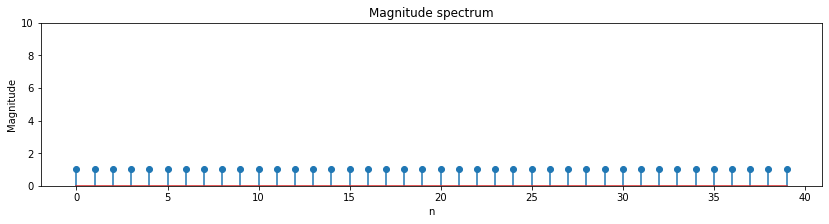

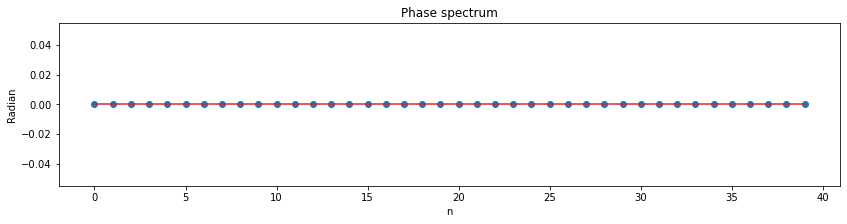

In [19]:
draw_spec(spec_imp)

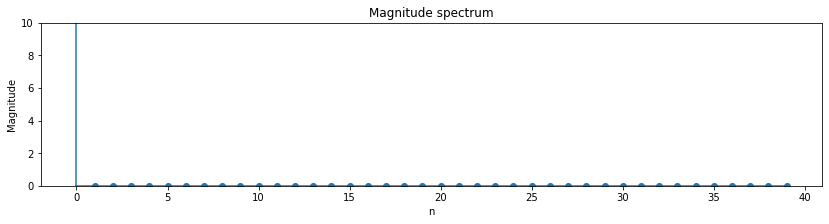

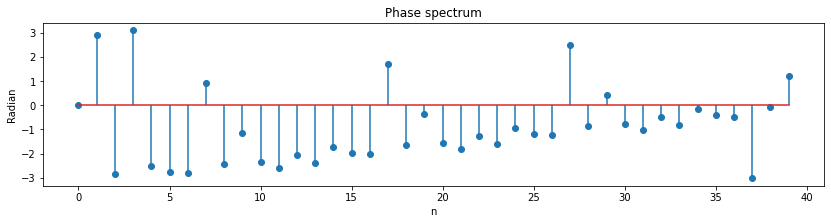

In [20]:
draw_spec(spec_scach)

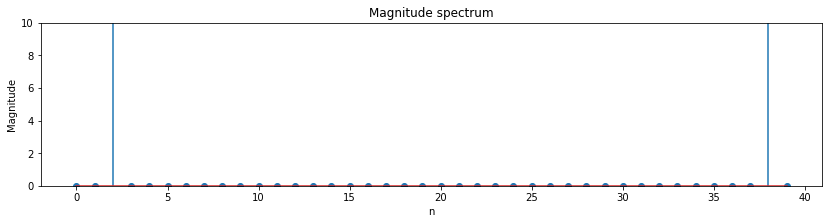

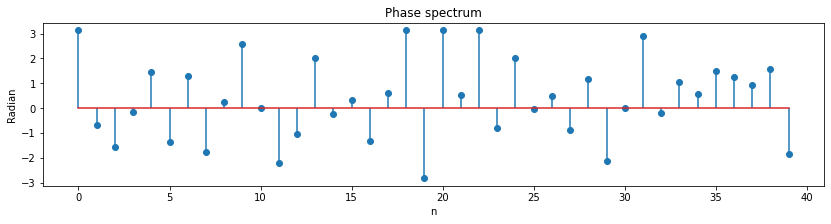

In [21]:
draw_spec(spec_sin)

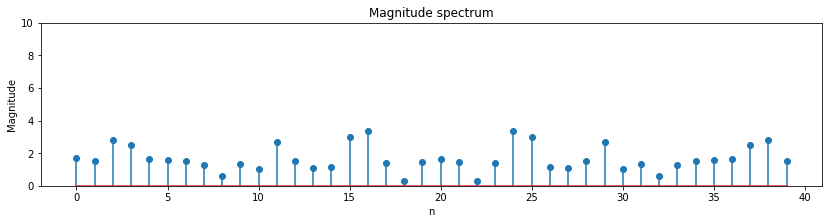

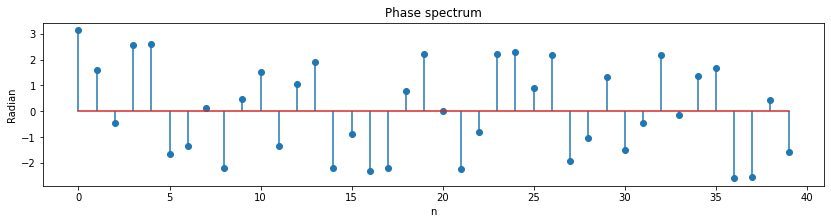

In [22]:
draw_spec(spec_n)

1. Почему амплитуда всех гармоник единичного импульса равна константе? 
1. Какие выводы можно сделать смотря на амплитудный спектр? А на фазовый? 
1. Как перевести номер отсчета в частоту?  
1. Что в фазовом спектре является полезной информацией, а что - шумом? Почему?

1. - Применим преобразование Фурье $X(k) = \sum_{n=0}^{N-1}\delta(n)e^{-j\frac{2\pi}{N}kn}$ для единичного импульса по отсчетам x(n). Получим, что $\delta(n)$ = 0, кроме n=0. В нуле же он = 1(либо константе). Экспонента = 1. Поэтомуу для каждого гармоники k, её амплитуда будет равно константе.
2. - По амплитудному спектру - вывод обо всех составляющие со своими амплитудами и частотами. В фазовом спектре —  обо составляющих с начальными фазами и частотами. 
3. - Воспользоваться формулой: $f_k = \frac{f_д}{N} k$, где k - номер отсчета
4. - В фазовом спектре находится информация о сигнале.

# Оконное преобразование Фурье
Преобразование Фурье делает переход из временной области в частотную, позволяя анализировать составляющие сигнал гармоники. Однако это не всегда удобно. В реальных сигналах зачастую составляющие их гармоники изменяются со временем. Например, каждая буква в слове имеет свой набор основных гармоник, и простое преобразование Фурье не сильно поможет нам определить, что было сказано. Для того, чтобы анализировать такие сигналы, обычно используется [Оконное преобразование Фурье](https://ru.wikipedia.org/wiki/Оконное_преобразование_Фурье). Такое преобразование позволяет анализировать гармоники сигнала в коротких промежутках времени и сохранить временную ось при построении спектрограммы.
# Задание 3 (2 балла)
Реализовать оконное преобразование Фурье, пользуясь только библиотеками numpy и scipy. Сравнить с librosa.stft


In [31]:
def frame(x, frame_length, hop_length):

    n_frames = 1 + (x.shape[-1] - frame_length) // hop_length
    strides = np.asarray(x.strides)
    new_stride = np.prod(strides[strides > 0] // x.itemsize) * x.itemsize
    shape = list(x.shape)[:-1] + [frame_length, n_frames]
    strides = list(strides) + [hop_length * new_stride]
    
    return as_strided(x, shape=shape, strides=strides)

In [32]:
def STFT(x, n_fft=2048, hop_length=512, window='hann'):

    fft_window = scipy.signal.get_window(window, n_fft, fftbins=True)
    fft_window = fft_window.reshape((-1, 1))
    
    x = np.pad(x, int(n_fft // 2), mode="reflect")

    y_frames = frame(x, frame_length=n_fft, hop_length=hop_length)

    spectrogram = np.zeros((int(1 + n_fft // 2), y_frames.shape[1]), dtype=np.complex)
    step = len(x) // n_fft
    for start in range(0, spectrogram.shape[1], step):
        stop = min(start + step, spectrogram.shape[1])
        spectrogram[:, start:stop] = np.fft.rfft(fft_window * y_frames[:, start:stop], axis=0)
    
    return spectrogram

In [33]:
def test_stft(x, n_fft=2048, hop_length=512, window='hann'):
    librosa_result = librosa.stft(x, n_fft=n_fft, hop_length=hop_length, window='hann', center=True)
    result = STFT(x, n_fft=n_fft, hop_length=hop_length, window='hann')
    if librosa_result.shape != result.shape:
        print(f"Your shape {result.shape} != librosa stft shape {librosa_result.shape} ")
        return -1 
    if not np.allclose(librosa_result, result):
        print(f"Wrong results. Diff {np.abs(librosa_result-result)}")
        return -2
    return 0
        
for name, sig in signals.items():
    print(f"Checking '{name}'")
    for n_fft in (8, 4):
        for hop_length in (n_fft//4, n_fft//2):
            assert test_stft(sig, n_fft=n_fft, hop_length=hop_length)==0, \
                f"Test failed. Params n_fft {n_fft}. Hop_length {hop_length}"
    print("ok")
print("All ok!")

Checking 'Единичный импульс'
ok
Checking 'Единичный скачок'
ok
Checking 'Синус'
ok
Checking 'Шум'
ok
All ok!


In [34]:
# Определим функцию для отрисовки
def draw_stft(X, sr, figsize=(14, 5)):
    plt.figure(figsize=figsize)
    # X - комплекстная спектрограмма 
    # Для получения энергии достаточно взять модуль
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.show()

# Анализ сигналов
Теперь можно приступить к анализу звуковых сигналов.
Во время анализа сигналов нам понадобятся все определенные выше инструменты. 


----------------------------------
## Анализ паровозного гудка
Начнем с простого сигнала, состоящего из нескольких основных гармоник и шума.

Len is 82175 ( ). Sample rate is 22050


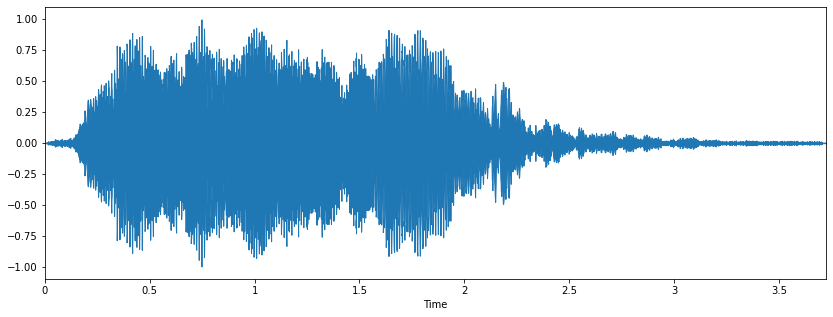

In [35]:
# Загрузим аудио файл с паровозным гудком
train_whistle, tw_sr = librosa.core.load("resources/train_whistle.wav")
print(f"Len is {len(train_whistle)} ( ). Sample rate is {tw_sr}")
player = ipd.Audio(train_whistle, rate=tw_sr)
ipd.display(player)
draw_waveform(train_whistle, sr=tw_sr)

Гудок паровоза в частотной области


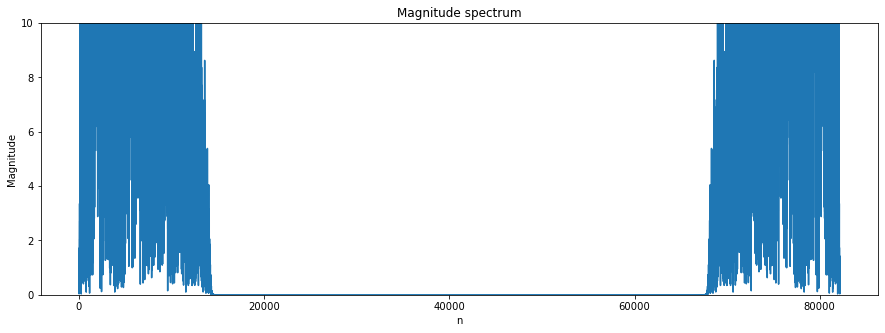

In [36]:
train_whistle_spec = scipy.fft.fft(train_whistle)
print("Гудок паровоза в частотной области")
draw_spec(train_whistle_spec, draw_p=False, figsize=(15,5))

# Задание 4 (2 балла)
Определите 3 основные гармоники паровозного гудка.

Ответ округлите до двух знаков после запятой.


In [46]:
N = len(train_whistle)
T = 1 / tw_sr
xf = fftfreq(N, T)[:N//2]
yf = 2.0 / N * np.abs(train_whistle_spec[0:N//2])

In [47]:
u_p = interp1d(xf, yf, kind = 'cubic',bounds_error = False, fill_value=0.0)
xnew = np.linspace(0, len(xf), num=len(xf) * 4)
ynew = u_p(xnew)

min_peak_heigth = 0.03
indices = find_peaks(ynew, height=min_peak_heigth, width=2)[0]
peaks = np.array([round(xnew[x], 2) for x in indices])

step = 20
start = int(peaks.min()) - step
stop = int(peaks.max()) + step
max_peak = {}
for i in range(start, stop + step, step):
    peaks_tmp = peaks[np.where((np.array(peaks) > i - step) & (np.array(peaks) < i))]
    if len(peaks_tmp) != 0:
        peaks_tmp_val = np.array([u_p(x) for x in peaks_tmp])
        max_freq = peaks_tmp[peaks_tmp_val.argmax(axis=0)]
        max_peak[max_freq] = float(u_p(max_freq))

task_answer = sorted(max_peak, key=max_peak.get, reverse=True)[:3]

In [48]:
assert type(task_answer) == list or type(task_answer) == np.ndarray, \
        f"Wrong answer type. Expected list or numpy array. Got {type(task_answer)}"
assert len(task_answer) == 3, \
        f"Wrong len {len(task_answer)}."
assert (round(sum(task_answer)) == 1677 and round(np.var(task_answer)) == 1407) or \
        (abs(sum(task_answer)  - 1836) <= 3 and abs(np.var(task_answer) - 10153) <= 181), \
        f"Wrong freqs"
print("Correct!")       

Correct!


Теперь попробуйте сгенерировать сигнал, состоящий только из этих гармоник. Воспроизведите сигнал.

In [57]:
duration = 3.0   
ys = np.sum(np.sin(np.multiply(2 * np.pi * np.arange(fs * duration), (np.array(task_answer) / fs).reshape(3, 1))), axis=0)
music = ipd.Audio(ys, rate=fs)
ipd.display(music)

# Анализ двухтонального многочастотного сигнала
Теперь расмотрим более сложный сигнал - [DTMF](https://en.wikipedia.org/wiki/Dual-tone_multi-frequency_signaling). Такие сигналы используются для автоматизации набора телефонного номера. 

# Задание 5 (2 балла)
В данном аудио закодирован трехзначный номер. Используя таблицу с [wiki]:(https://ru.wikipedia.org/wiki/DTMF) определите, что за номер закодирован.


Len is 243102. Sample rate is 22050


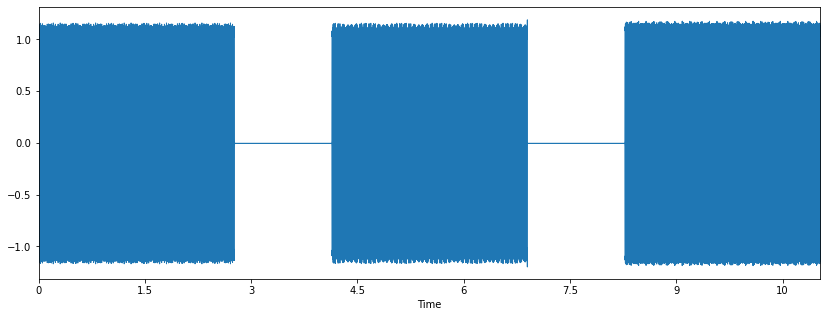

In [58]:
#dtmf.wav
dtmf, dtmf_sr = librosa.core.load("resources/dtmf.wav")
print(f"Len is {len(dtmf)}. Sample rate is {dtmf_sr}")
player = ipd.Audio(dtmf, rate=dtmf_sr)
ipd.display(player)
draw_waveform(dtmf, sr=dtmf_sr)

In [62]:
# YOUR CODE HERE
# phone_number = [first: int, second: int, third: int]


In [63]:
assert type(phone_number) == list or type(phone_number) == np.ndarray, \
        f"Wrong answer type. Expected list or numpy array. Got {type(phone_number)}"
assert len(phone_number) == 3, \
        f"Wrong len {len(phone_number)}."
assert round(np.mean(phone_number)) == 5 and round(np.var(phone_number)) == 11 , \
        f"Wrong number"
assert hashlib.md5(''.join(map(str, phone_number)).encode()).hexdigest() == "140f6969d5213fd0ece03148e62e461e", \
        f"Wrong hash. How did you pass mean/var test?"
print("Correct!")   

AssertionError: Wrong len 2.